In [207]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

## Singleton Estimation

We want to estimate the number of singletons that we can expect to have for skeleton tree reconstruction

<b> Variables to Consider:</b>

- num_targets - number of potential target sites 
- mut_rate - mutation rate per target site
- edit_distribution - distribution over potential edits per target site

<hr>

<b> Simulation Formulation </b>

We begin each simulation with one cell, representing the fertilised egg, that has all its targets in an unmutated state. The initial cell then undergoes a series of cell divisions (d), growing into a population of N cells, where $N=2^d$. Following each cell division, each unmutated target can mutate (with a given probability μd) to one of several possible mutated states. Once a target is mutated, it can no longer change, either to revert to the unmutated state or to transit to a new state.


<b> Useful References </b>

<sub> [1]https://elifesciences.org/articles/40292


</sub>

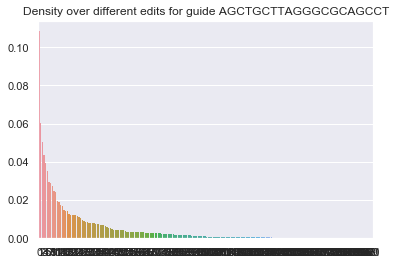

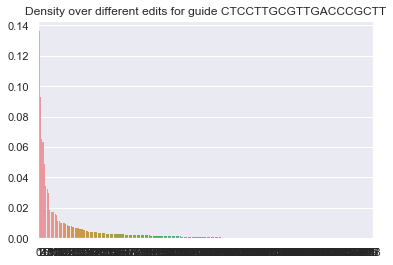

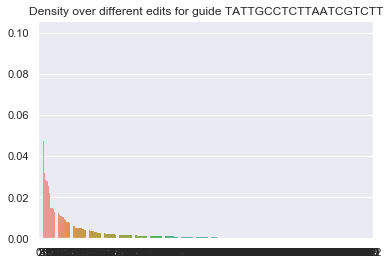

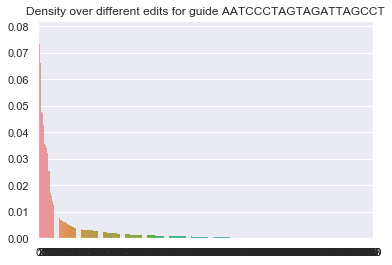

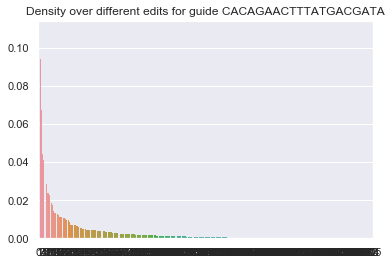

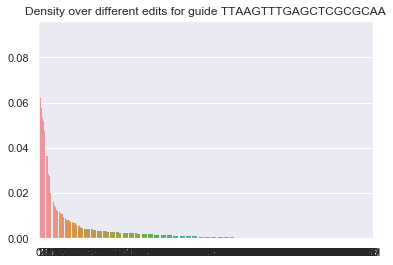

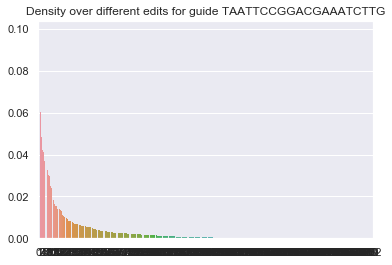

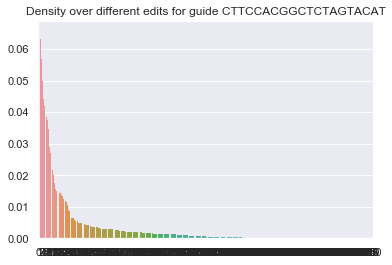

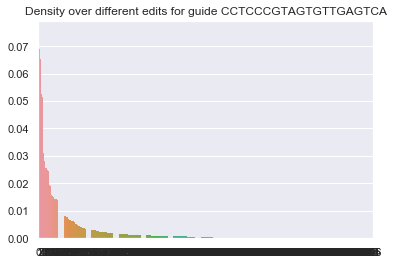

In [208]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('/Users/sitarapersad/Downloads/d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        plt.figure()
        sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
        plt.title('Density over different edits for guide {0}'.format(guide))
        plt.show()
        plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]




In [209]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""


Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


' \nQuestions\n1. tree or forest\n2. are the rates based on isolating a clone or from a forest\n3. yosef lab was a single tree?? no\n\ntry this instead: \nstart with many roots (a forest)\n\nreproduction rate varying / same ?vfr \n\n'

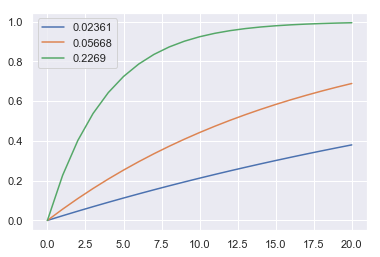

In [210]:
plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

In [767]:
# # Store simulation result
# class SimulationResult(self):
#     def __init__(self, label, run=None):
#         self.label = label
#         self.run = run 
        
#         self.num_arrays
#         self.num_sites 
#         self.tree_depth
#         self.subsampled_size
        
#         self.available_sites_per_gen
#         self.edits_made_per_gen
        
#         self.subsampled_recurring_edits
#         self.subsampled_edits_made_per_gen
#         self.subsampled_available_sites_per_gen
#         self.subsampled_num_cells_per_gen 
        
        
        

## Identifying Recurrent Mutations

In [795]:
def identify_recurrent(subsampled_record, recurring_edits):
    # Test every pair of mutations and identify those which are in conflict
    final_cells = pd.DataFrame(subsampled_record[-1])
    print(final_cells.shape)
    x = final_cells.values

    import time
    t = time.time()
    # For each target site, access all the mutations
    muts = {}
    for col in range(x.shape[1]):
        unique_muts  = np.unique(x[:, col][x[:, col]!=0]) 

        m_list = []
        for m in unique_muts:
            count = (subsampled_record[-1][:, col] == m).sum(0)
            if count >= 2:
                m_list.append(m)
        muts[col] = m_list

        print(len(unique_muts), 'vs', len(m_list))

    print('Time 1:', time.time()-t)
    # Iterate over all pairs of mutations and determine whether they are in conflict)
    conflicts_with = {}

    sites = list(muts.keys())
    n_sites = len(sites)

    t1 = time.time()
    # See 4-gamete test: A pair of mutations are in conflict if we observe A with B, A without B and B without A.
    for i in range(n_sites):
        for m1 in muts[i]:
            yes_cells = final_cells[final_cells[i] == m1]
            no_cells = final_cells[final_cells[i] != m1]

            for j in range(i+1, n_sites):
                for m2 in muts[j]:
                    pair = (i,m1), (j,m2)
                    A,B = pair

                    # Find all the cells that contain both A and B. If none exist, we move on.
                    if not (yes_cells[j] == m2).any():
                        continue

                    # Find all the cells that contain only A. If none exist, we move on.
                    if not (yes_cells[j] != m2).any():
                         continue

                    # Find all the cells that contain only B. If none exist, we move on.
                    if not (no_cells[j] == m2).any():
                         continue

                    # Mutations A and B are in conflict
                    conflicts_with[A] = conflicts_with.get(A, []) + [B]                
                    conflicts_with[B] = conflicts_with.get(B, []) + [A]

    print('Compute dictionary:', time.time()-t)               



    all_conflicting = list(conflicts_with.keys())
    num_conflicting = [len(conflicts_with[a]) for a in all_conflicting]

    mut_to_ix = {}
    ix_to_mut = {}
    i = 0
    for mut in all_conflicting:
        mut_to_ix[mut] = i
        ix_to_mut[i] = mut
        i += 1
    total_muts = i

    conflict_matrix = np.zeros((total_muts, total_muts))

    for m1 in conflicts_with:
        for m2 in conflicts_with[m1]:
            conflict_matrix[mut_to_ix[m1], mut_to_ix[m2]] = 1

    def check_symmetric(a, tol=1e-8):
        return np.all(np.abs(a-a.T) < tol)

    print('Conflict matrix is symmetric? ', check_symmetric(conflict_matrix))
    runtime = time.time()-t
    print('Total time:', runtime) 

    true = set(recurring_edits.keys())
    inferred = set(conflicts_with.keys())
    print('Number of true recurrent muts: ', len(true))
    print('Number of detected recurrent muts: ', len(inferred))
    undetected = true - true.intersection(inferred)
    prevalence = []
    for m in undetected:
        prevalence.append(sum(subsampled_record[-1][:, m[0]]==m[1]))
    print('Number of true recurrent muts not detected:', len(undetected), 'with prevalence', prevalence)

    # For each identified conflicting mutation, get the number of times it recurred
    num_recur_tape = np.zeros(total_muts)
    for mut in all_conflicting:
        num_recur_tape[mut_to_ix[mut]] = len(gen_occurred[mut])

    # For each identified conflicting mutation, get the generation the mutation first existed
    first_gen_tape = np.zeros(total_muts)
    for mut in all_conflicting:
        first_gen_tape[mut_to_ix[mut]] = gen_occurred[mut][0]

    # For each identified conflicting mutation, what is the prevalence in the final generation?
    prevalence_tape = np.zeros(total_muts)
    for mut in all_conflicting:
        prevalence_tape[mut_to_ix[mut]] = sum(subsampled_record[-1][:, mut[0]]==mut[1])

    # Identify which conflicting muts are true 
    truth = []
    for mut in all_conflicting:
        truth.append(int(mut in recurring_edits))

    sns.set(rc={'axes.facecolor':'gainsboro'})

    f, axes = plt.subplots(8, 1, sharex=True, gridspec_kw={'height_ratios': [5, 0.5, 1, 1, 1, 1, 1,1 ]}, figsize=(10,30))
    sns.heatmap(conflict_matrix, cmap='Paired', ax=axes[0], cbar_kws = dict(use_gridspec=False,location="top"))
    axes[0].set_title('Conflict Matrix')
    sns.heatmap([truth], cmap='Paired', ax=axes[1], cbar=False)
    axes[1].set_title('True Mutations')
    sns.heatmap([conflict_matrix.sum(0)], cmap=sns.color_palette("Blues"), ax=axes[2], cbar_kws = dict(use_gridspec=False,location="bottom"))
    axes[2].set_title('Number of Co-conflicting Mutations')

    axes[3].plot(num_recur_tape)
    axes[3].set_title('Number of Recurrences')

    axes[4].plot(first_gen_tape)
    axes[4].set_title('Generation of First Occurrence')

    axes[5].plot(prevalence_tape)
    axes[5].set_title('Prevalence in Final Generation')

    axes[6].plot(conflict_matrix.sum(0))
    axes[6].set_title('Number of Co-conflicts')
    axes[7].plot(truth, '*')
    axes[7].set_title('Truth')

    axes[7].set_xticklabels(axes[4].get_xticklabels(), rotation=75)
    plt.show()
    plt.close()



    df = {'truth':truth, 'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ], 'co-conflicts':conflict_matrix.sum(0), 
          'prevalence': prevalence_tape, 'first_occur': first_gen_tape, 'num_recur': num_recur_tape}
    df = pd.DataFrame(df)

    pd.melt(df)

    g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend()
    g.fig.suptitle("Relationship Between Metrics", y=1) # y= some height>1
    plt.show()
    plt.close()

    return runtime, all_conflicting, conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape  



## Greedy Tree Construction

    # Why does NJ take so long?? Try doing Camin Sokal or NJ as well 

In [796]:
def split_tree(x, min_cells = 10):
    """
    Warning! Modifies the object x
    """
    # Stop splitting if all the cells are the same or there are fewer than min_cells in the subtree 
    if x.shape[0] <= min_cells:
        x['Label']+='.'
        return x
    
    mode, counts = stats.mode(x.drop('Label',axis=1).values, axis=0, nan_policy = 'omit')
    counts = counts[0]
    mode = mode[0]
    col = np.argsort(counts)[-1]
    edit = mode[col]
    
    # Split tree into cells which contain this edit and those who don't
    ix = (x[col]==edit)
    contains = x.index[ix]
    not_contains = x.index[~ix]

    x.loc[contains,'Label'] += '1'
    x.loc[not_contains,'Label'] += '0'
    
    # Remove this edit (no need to use it again)
    x.loc[ix, col] = np.nan
    
    
    if np.nansum(x.drop('Label', axis=1).values) == 0:
        print('No more mutations to split on, returning.')
        return x 
    
    # Recurse on each individual subtree and label accordingly
    if len(contains) > 0:
        x.loc[contains] = split_tree(x.loc[contains]) 
    
    if len(not_contains) > 0:
        x.loc[not_contains] = split_tree(x.loc[not_contains])
    
    return x



<hr>
## Triplets correct statistic
To compare the similarity of simulated trees to reconstructed trees, we take an approach which compares the
sub-trees formed between triplets of the terminal states
across the two trees. To do this, we sample ∼ 10, 000
triplets from our simulated tree and compare the relative
orderings of each triplet to the reconstructed tree. We say
a triplet is “correct” if the orderings of the three terminal states are conserved across both trees. This approach
is different from other tree comparison statistics, such
as Robinson-Foulds [34], which measures the number of
edges that are similar between two trees.
To mitigate the effect of disproportionately sampling
triplets relatively close to the root of the tree, we calculate
the percentage of triplets correct across each depth within
the tree independently (depth measured by the distance
from the root to the latest common ancestor (LCA) of
the triplet). We then take the average of the percentage
triplets correct across all depths. To further reduce the
bias towards the few triplets that are sampled at levels
of the tree with very few cells (i.e., few possible triplets),
we modify this statistic to only take into account depths
where there at least 20 cells. We report these statistics
without this depth threshold in Additional file 1: Fig S8
           
Ordering -> Cells share common ancestors in the correct order:

{{AB}C} vs {A{BC}}



In [797]:
def compute_triplets_correct(final_cells_labeled, subsampled_ix, sample_size = 1000):
    def get_ordering(a,b,c):
        """
        Return which cell (A,B or C) was least related of the triplet.
        e.g.
             ___A    
         ____|
        |    |___B
        |    
        |________C

        returns C
        """

        # The last (least significant) digit which agree across cells is the depth of their most recent common ancestor

        max_depth = {}
        for i in range(min(len(a),len(b))):
            if a[i] != b[i]:
                max_depth['ab'] = i
                break

        for i in range(min(len(a),len(c))):
            if a[i] != c[i]:
                max_depth['ac'] = i
                break


        for i in range(min(len(c),len(b))):
            if c[i] != b[i]:
                max_depth['bc'] = i
                break

        vals = list(max_depth.values())
        max_val = max(vals)
        if len(set(vals)) == 1:
            # All are at same depth
            return '='
        elif max_depth['ac'] == max_val:
            return 'B'
        elif max_depth['bc'] == max_val:
            return 'A'
        if max_depth['ab'] == max_val:
            return 'C'

    def cell_ix_to_label(i):
        return (format(i-1, '#022b')[2:])

    num_correct = 0
    for _ in range(sample_size):
        # Randomly sample triplets (a,b,c) and determine the relative ordering of ancestry.
        # How many are consistent with the truth?
        ix = np.random.choice(np.arange(subsampled_ix.shape[0]), 3, replace=False)
        a,b,c = (cell_ix_to_label(i) for i in subsampled_ix[ix])
        truth = get_ordering(a,b,c)

        # Grab the corresponding cells from our final array
        a,b,c = final_cells_labeled['Label'].iloc[ix]
        inferred = get_ordering(a,b,c)

        if truth == inferred:
            num_correct += 1

    print('Proportion correct = ', num_correct/sample_size)
    
    return num_correct/sample_size

Label: sss
num_targets 3
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
1 cell(s) at depth 0
2 cell(s) at depth 1
4 cell(s) at depth 2
8 cell(s) at depth 3
16 cell(s) at depth 4
32 cell(s) at depth 5
64 cell(s) at depth 6
128 cell(s) at depth 7
256 cell(s) at depth 8
512 cell(s) at depth 9
1024 cell(s) at depth 10
2048 cell(s) at depth 11
4096 cell(s) at depth 12
8192 cell(s) at depth 13
16384 cell(s) at depth 14
32768 cell(s) at depth 15
65536 cell(s) at depth 16
131072 cell(s) at depth 17


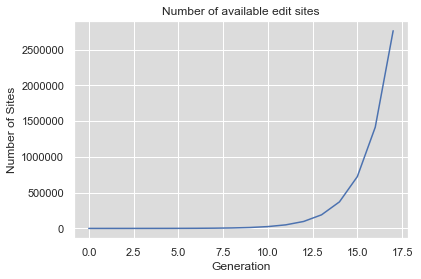

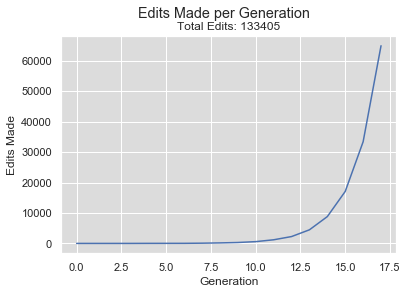

262144 cell(s) at depth 18


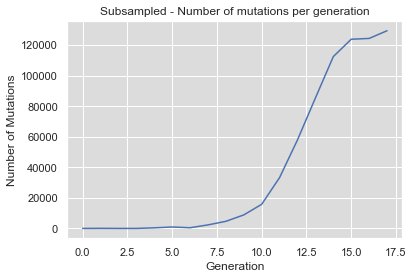

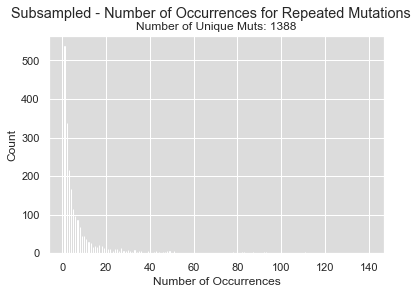

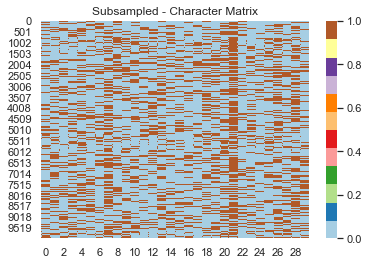

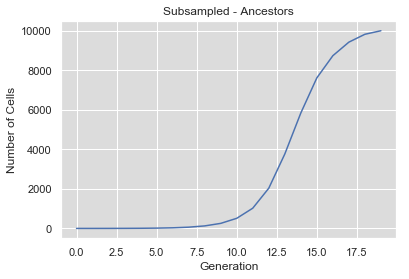

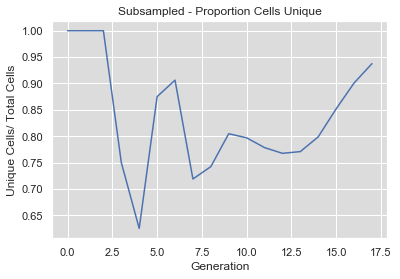

Proportion correct =  0.319
(10000, 30)
118 vs 100
142 vs 108
153 vs 113
122 vs 97
123 vs 88
139 vs 103
119 vs 97
106 vs 83
127 vs 92
117 vs 91
134 vs 98
147 vs 107
115 vs 92
125 vs 95
151 vs 113
116 vs 87
135 vs 103
145 vs 102
111 vs 84
124 vs 93
138 vs 97
91 vs 66
135 vs 103
153 vs 105
125 vs 99
132 vs 102
149 vs 98
117 vs 94
120 vs 88
144 vs 104
Time 1: 0.16482996940612793
Compute dictionary: 1119.5469210147858
Conflict matrix is symmetric?  True
Total time: 1119.834422826767
Number of true recurrent muts:  2170
Number of detected recurrent muts:  2870
Number of true recurrent muts not detected: 0 with prevalence []


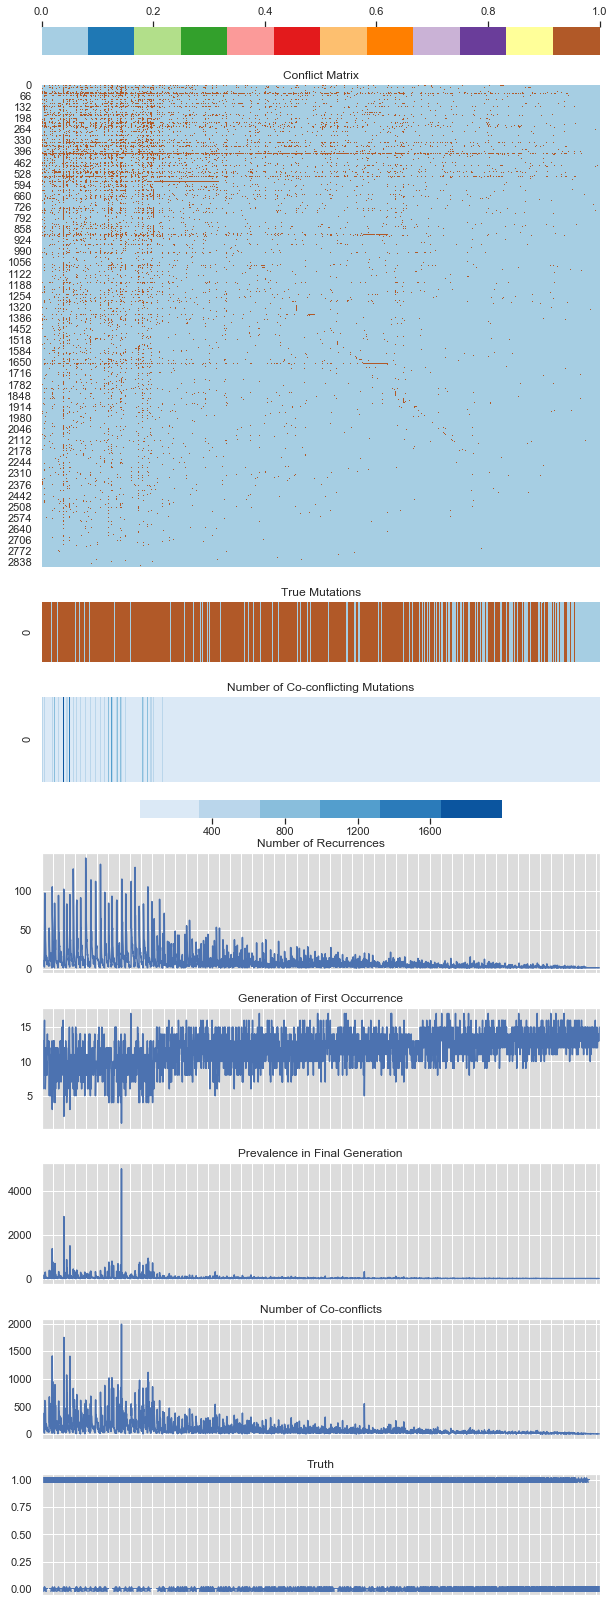

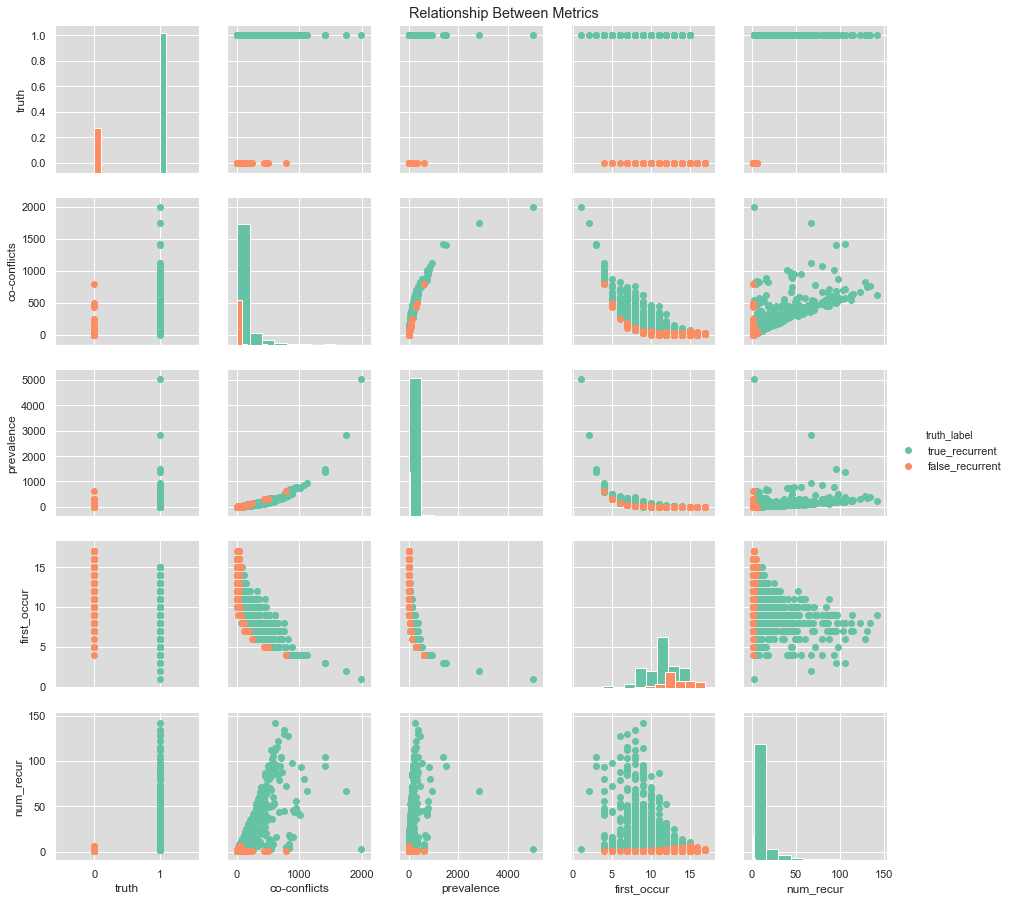

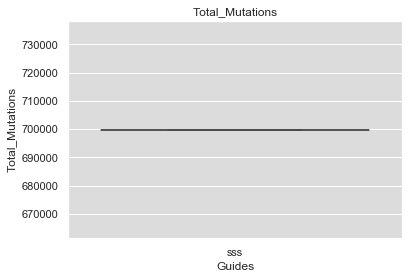

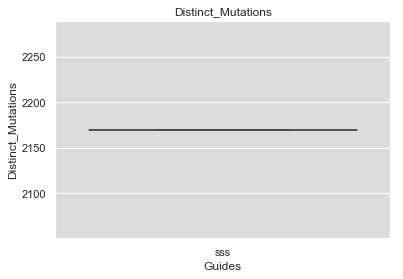

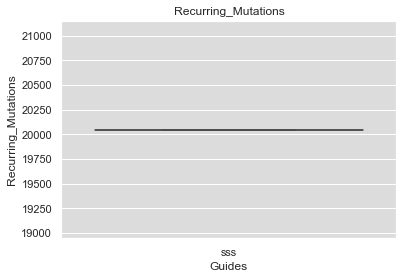

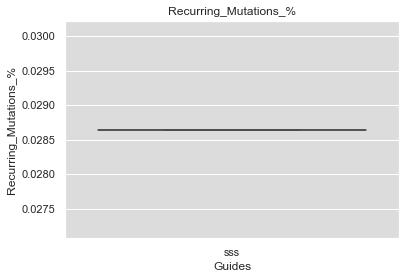

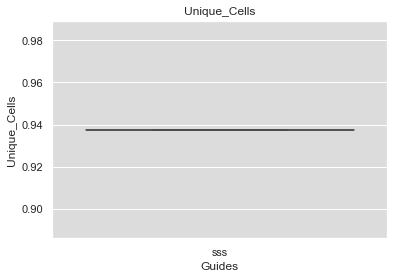

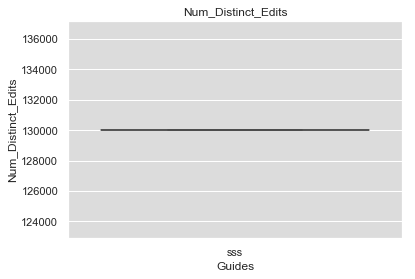

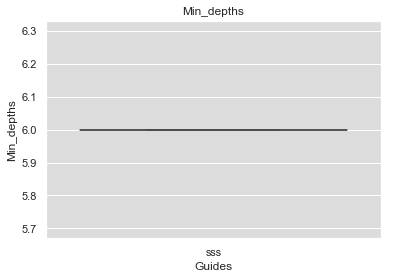

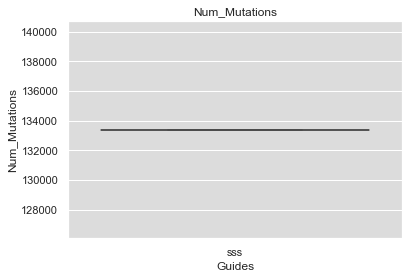

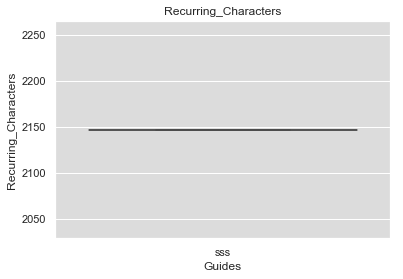

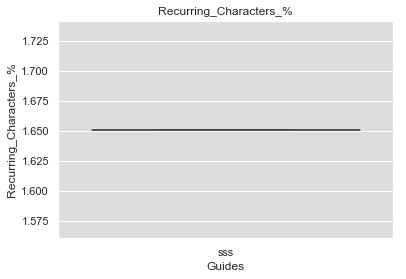

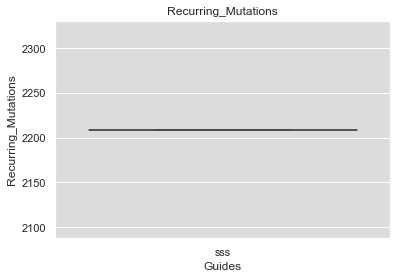

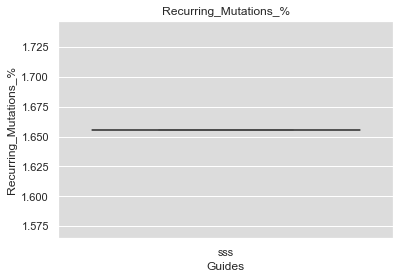

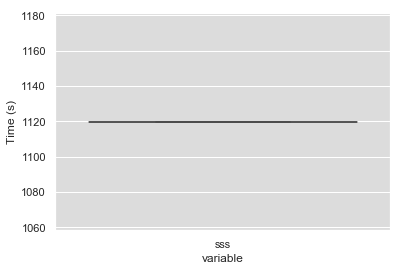

In [798]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 10000
num_arrays = 10

debug = True
compute_tree = True

if debug:
    lists_of_guides = lists_of_guides[:1]
    labels = labels[:1]
    tree_depth = 18
    num_runs = 1
    n_subsample = 10000
    num_arrays = 10
    
for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)
    
    timers[label] = []
        
    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites

    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    print('num_targets', num_targets)
    

    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
    
    deletions_weights = pd.DataFrame(deletions)
    deletions_weights = torch.DoubleTensor(deletions_weights.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)

    

    num_edits = []
    min_depths = []
    num_recurring_chars = []
    proportion_recurring_chars = []
    num_recurring_muts = []
    proportion_recurring_muts = []
    num_mutations_list = []
    novel_edit_list = []
    
    records = []
    subsampled_records = []
    subsampled_edits_records = []
    subsampled_recurring_edits_records = []
    
    ss_recurring_muts = []
    ss_distinct_recurring_muts = []
    ss_total_muts = []
    
    unique_cell_list = [] 
    for run in range(num_runs):
    
        # Simulating a tree: we start out with a single cell which is unmutated
        cell_recorder = np.zeros((1, num_edit_sites))
        min_depth = np.nan


        # TODO: Fix this reproduction probability
        reproduction_prob = 1.0 


        edits_occurred = set([])
        convergence = {}
        num_mutations = 0
        record = [cell_recorder]
        edit_record = []
        
        available_sites = []
        edits_made = []
        for i in range(tree_depth):
            # One round of CRISPR may happen between this generation's division 
            # and the previous generation

            num_cells = cell_recorder.shape[0]

            print('{0} cell(s) at depth {1}'.format(num_cells, i))

            # TODO: Will each cell divide? And at what rate? This should be considered
            reproducting = np.random.random((num_cells, num_edit_sites)) <= reproduction_prob

            # For each target, mutate with a fixed probability
            # This probability empirically estimated from MSKCC data with 
            # the assumption of fixed reproduction time.

            # An edit occurs if 
            # (1) the probability drawn is sufficient and 
            mutating = np.random.random((num_cells, num_edit_sites)) <= mutation_probs

            # (2) the site is not already edited.
            not_edited = cell_recorder == 0 
            
            available_sites.append(not_edited.sum())
            edit_here = mutating & not_edited
            
            edits_made.append(edit_here.sum())
            num_mutations += edit_here.sum()
            
            novel_edits = edit_here
            if edit_here.sum() > 0:
                # For the cells and targets which are mutating, now draw a deletion 
                # from the distribution specific to that. Deletions are indexed starting at 1
                deletion_choice = 1 + torch.multinomial(torch.DoubleTensor(deletions_weights), num_cells, replacement=True).numpy().T
                deletion_choice[~edit_here] = 0
                novel_edits = deletion_choice 
                sites, cells = np.where(deletion_choice !=0)
                
                site_edits = list(zip(sites, deletion_choice[(sites, cells)]))
                intersection = edits_occurred.intersection(site_edits)

                for edit in intersection:
                    if verbose:
                        print('{0} already occurred before {1}'.format(edit, i))
                    # If a sampled (target, deletion) has already occurred, 
                    # then note the tree depth before we have 'convergent' evolution
                    convergence[edit] = convergence.get(edit, []) + [i]
                    if np.isnan(min_depth):
                        min_depth = i

                # Update the list of (target, deletions) that have already occurred.
                edits_occurred = edits_occurred.union(site_edits)    


                cell_recorder += deletion_choice 
                if verbose:
                    print('after')
                    print(cell_recorder)
            
            record.append(cell_recorder)
            edit_record.append(novel_edits)
            
            # New cell_recorder has double the entries after replication
            # TODO: Only allow some cells to replicate    
            cell_recorder = np.repeat(cell_recorder, 2, axis=0)
        
        # Plot some dynamics of simulation
        plt.figure()
        plt.title('Number of available edit sites')
        plt.plot(available_sites)
        plt.xlabel('Generation')
        plt.ylabel('Number of Sites')
        plt.show()
        plt.close()
        
#         simulation.available_sites = available_sites
        
        plt.figure()
        plt.suptitle('Edits Made per Generation')
        plt.title('Total Edits: {0}'.format(sum(edits_made)))
        plt.plot(edits_made)
        plt.xlabel('Generation')
        plt.ylabel('Edits Made')
        plt.show()
        plt.close()
        
#         simulation.edits_per_gen = edits_made
#         simulation.full_cell_recorder = cell_recorder
        
        record.append(cell_recorder)
        num_cells = cell_recorder.shape[0]
        print('{0} cell(s) at depth {1}'.format(num_cells, tree_depth))
        
        num_edits.append(len(edits_occurred))
        num_mutations_list.append(num_mutations)
        min_depths.append(min_depth)
        num_recurring_chars.append(len(convergence))
        num_recurring_muts.append(sum([len(val) for val in convergence.values()]))
        proportion_recurring_chars.append(len(convergence)/max(1, len(edits_occurred)))
        proportion_recurring_muts.append(num_recurring_muts[-1]/max(1, num_mutations))
        
        # Record history of cells 
        novel_edit_list.append(edit_record)
        records.append(record)
    
        # Subsample cells 
        subsampled_ix = np.random.choice(cell_recorder.shape[0], n_subsample, replace=False)
        subsampled = cell_recorder[subsampled_ix, :]
        
        # We only care about the ancestors of these subsampled cells
        subsampled_record = []
        level_ix = subsampled_ix
        for i, ix in enumerate(range(len(record)-1, -1, -1)):
            rec = record[ix]
            subsampled_record.append(rec[level_ix, :])
            level_ix = pd.unique(level_ix//2)
        subsampled_record.reverse()
    
    
        subsampled_records.append(subsampled_record)
        # We only care about edits related to these subsampled cells
        # The edit at index i corresponds to the parents of the
        level_ix = subsampled_ix
        subsampled_edits = []
        for rec in reversed(edit_record):
            level_ix = pd.unique(level_ix//2)
            subsampled_edits.append(rec[level_ix, :])
        subsampled_edits.reverse()
        
        subsampled_edits_records.append(subsampled_edits)
        
        recurring_edits = {} # Mapping (site, deletion) to a list of generations where the mutation reoccured. 
        gen_occurred = {}
        for gen in range(1, tree_depth):
            rows, cols = np.where(subsampled_edits[gen]!=0)
            edits = subsampled_edits[gen][np.where(subsampled_edits[gen]!=0)]
            for col, edit in zip(cols, edits):
                # Track the generation that each mutation occurred
                gen_occurred[(col,edit)] = gen_occurred.get((col, edit), []) + [gen]
                # Track only recurrent mutations
                if ((subsampled_record[gen - 1 ][:, col] == edit).sum()) > 0:
                    # Add this (position, deletion) pair to the list of recurring muts
                    recurring_edits[(col, edit)] = recurring_edits.get((col, edit), []) + [gen]
        
        subsampled_recurring_edits_records.append(recurring_edits)
        
        # Track subsampled statistics:
        
        # How many mutations were recurring 
        ss_recurring_muts.append(sum([len(x) for x in recurring_edits.values()]))
        # How many distinct mutations re-occurred (>1 times)
        ss_distinct_recurring_muts.append(len(recurring_edits))
        # Total number of mutation events that happened
        ss_total_muts.append(sum([x.sum() for x in subsampled_edits]))
        
        # Plot the number of mutations that occurred per generation
        plt.figure()
        plt.plot(np.arange(tree_depth), [x.sum() for x in subsampled_edits])
        plt.xlabel('Generation')
        plt.ylabel('Number of Mutations')
        plt.title('Subsampled - Number of mutations per generation')
        plt.show()
        plt.close()
        
        # Plot the number of available sites per generation 
        
        
        plt.figure()
        plt.suptitle('Subsampled - Number of Occurrences for Repeated Mutations')
        total = 0
        for x in gen_occurred:
            if len(gen_occurred[x])==1:
                total+=1
        plt.title('Number of Unique Muts: {0}'.format(total))
        repeated = [len(x) for x in recurring_edits.values()]
        plt.hist(repeated, bins=len(repeated))
        plt.ylabel('Count')
        plt.xlabel('Number of Occurrences')
        plt.show()

        # Plot the character matrix of the final 
        plt.figure()
        sns.heatmap(subsampled_record[-1]!=0, cmap='Paired')
        plt.title('Subsampled - Character Matrix')
        plt.show()
        
        plt.figure()
        r_shapes = [r.shape[0] for r in subsampled_record]
        plt.plot(r_shapes)
        plt.title('Subsampled - Ancestors')
        plt.ylabel('Number of Cells')
        plt.xlabel('Generation')
        plt.show()

        unique_cell_per_gen = []
        for gen in range(tree_depth):
            final_cells = pd.DataFrame(subsampled_record[gen])
            unique_cells = final_cells.drop_duplicates().shape[0]/final_cells.shape[0]
            unique_cell_per_gen.append(unique_cells)
        plt.figure()
        plt.plot(unique_cell_per_gen)
        plt.xlabel('Generation')
        plt.ylabel('Unique Cells/ Total Cells')
        plt.title('Subsampled - Proportion Cells Unique')
        plt.show()
        unique_cell_list.append(unique_cells)
                        
        if compute_tree:
            final_cells = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
            final_cells['Label'] = '1'
            final_cells_labeled = split_tree(final_cells)
            final_cells = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
            final_cells['Label'] = '1'
            compute_triplets_correct(final_cells_labeled, subsampled_ix, sample_size = 1000)
        
        # Plot the tests for identifying recurrent mutations 
        result = identify_recurrent(subsampled_record, recurring_edits)
        runtime, all_conflicting, conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape = result 
        
        timers[label].append(runtime)
        
    # Summarise results for this combination of guides 
    results['Guides'] += [label]*num_runs
    results['Num_Distinct_Edits'] += num_edits
    results['Min_depths'] += min_depths
    results['Num_Mutations'] += num_mutations_list
    results['Recurring_Characters'] += num_recurring_chars
    results['Recurring_Mutations'] += num_recurring_muts
    results['Recurring_Characters_%'] += list(100*np.array(proportion_recurring_chars))
    results['Recurring_Mutations_%'] += list(100*np.array(proportion_recurring_muts))

    # Summarise results for this combination of guides 
    subsampled_results['Guides'] += [label]*num_runs
    subsampled_results['Total_Mutations'] += ss_total_muts
    subsampled_results['Distinct_Mutations'] += ss_distinct_recurring_muts
    subsampled_results['Recurring_Mutations'] += ss_recurring_muts
    subsampled_results['Recurring_Mutations_%'] += list(np.array(ss_recurring_muts)/np.array(ss_total_muts))
    subsampled_results['Unique_Cells'] += unique_cell_list

# Summarize results

df = pd.DataFrame(subsampled_results)
for y in ['Total_Mutations','Distinct_Mutations','Recurring_Mutations','Recurring_Mutations_%', 'Unique_Cells']:
    plt.figure()
    ax = sns.boxplot(x='Guides', y=y, data=df) #, order=['PICASSO Iter final', 'PICASSO Iter 0', 'PICASSO Iter 1'])
    plt.title(y)
    plt.show()
    plt.close()

df = pd.DataFrame(results)
for y in ['Num_Distinct_Edits', 'Min_depths', 'Num_Mutations','Recurring_Characters','Recurring_Characters_%','Recurring_Mutations','Recurring_Mutations_%']:
    plt.figure()
    ax = sns.boxplot(x='Guides', y=y, data=df) #, order=['PICASSO Iter final', 'PICASSO Iter 0', 'PICASSO Iter 1'])
    plt.title(y)
    plt.show()
    plt.close()
    
# How long did it take to run?
timer_df = pd.DataFrame(timers).melt()
sns.boxplot(x='variable', y='value', data=timer_df)
plt.ylabel('Time (s)')
plt.show()



In [799]:
compute_triplets_correct(final_cells_labeled, subsampled_ix, sample_size = 1000)

Proportion correct =  0.333


0.333

In [801]:
len(all_conflicting)

2870

In [802]:
conflict_matrix.shape

(2870, 2870)

## Evaluating the Effectiveness of Dropping Recurrent Mutations 

### Iterative Removal Process

In [883]:
def iterative_removal(conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape, all_conflicting):
    conflict_matrix = copy.deepcopy(conflict_matrix)
    truth = copy.deepcopy(truth)
    prevalence_tape = copy.deepcopy(prevalence_tape)
    first_gen_tape = copy.deepcopy(first_gen_tape)
    num_recur_tape = copy.deepcopy(num_recur_tape)
    mutations = copy.deepcopy(all_conflicting)
    
    removed = []
    removed_truth = []
    eliminated_truth = []
    first_good_mut = []
    first_good_mut_by_product = []
    
    total_muts = conflict_matrix.shape[0]
    print('Starting with {0} candidate recurrent mutations'.format(conflict_matrix.shape[0]))
    while conflict_matrix.shape[0] > 0:
        conflicts = conflict_matrix.sum(0)

        # How long until we remove a good mutation 
        sortIx = conflicts.argsort()[::-1]
        first_good_mut.append(np.where(np.array(truth)[sortIx]==0)[0][0])

        product = conflicts*prevalence_tape
        sortIx = product.argsort()[::-1]
        first_good_mut_by_product.append(np.where(np.array(truth)[sortIx]==0)[0][0])

        # Remove the mutation with the maximum number of conflicts
        conflicts = conflict_matrix.sum(0)
        max_ix = np.argmax(conflicts)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
        conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)
        # What mutation does this index map to?
        removed.append(mutations.pop(max_ix))
        removed_truth.append(truth.pop(max_ix))

        if not removed_truth[-1]:
            print('Removed a not-recurrent mutation!')

        first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
        prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
        num_recur_tape = np.delete(num_recur_tape, max_ix, axis=0)
        conflicts = np.delete(conflicts, max_ix, axis=0)

        # How has removing this mutation affected the number of conflicts for true vs false recurrent mutations 
        new_conflicts = conflict_matrix.sum(0)

        delta = conflicts - new_conflicts

        df = {'truth_label': ['true_recurrent' if i else 'false_recurrent' for i in truth ],  
               'co-conflicts_new':new_conflicts,'delta':delta, 'prevalence': prevalence_tape} #, 'first_occur': first_gen_tape, 'num_recur': num_recur_tape}
        df = pd.DataFrame(df)

        df['product'] = df['prevalence']*df['co-conflicts_new']
        df['div'] = df['co-conflicts_new']/df['prevalence']
        pd.melt(df)
        
        if len(removed) < 10:
            g = sns.PairGrid(df, hue = 'truth_label', palette="Set2")
            g.map_diag(plt.hist)
            g.map_offdiag(plt.scatter)
            g.add_legend()
            g.fig.suptitle("Change in Parameters after Removing Most Conflicting Mut", y=1) # y= some height>1
            plt.show()
            plt.close()

            df['co-conflicts_new'].hist(by=df['truth_label'])
            plt.suptitle('Number of Co-occuring Mutations after Removing {0} Mutations'.format(len(removed)))
            plt.xlabel('Number of Co-conflicts')
            plt.ylabel('Number of Mutations')
            plt.show()
            plt.close()

        # Remove rows, columns in conflict matrix with no conflicts
        no_conflict = np.where(conflict_matrix.sum(0)==0)[0][::-1] 
        #Reverse this so we can delete elements without messing up order

        for max_ix in no_conflict:
            conflict_matrix = np.delete(conflict_matrix, max_ix, axis=0)
            conflict_matrix = np.delete(conflict_matrix, max_ix, axis=1)

            eliminated_truth.append(truth.pop(max_ix))
            mutations.pop(max_ix)
            
            if eliminated_truth[-1]:
                print('Eliminated a recurrent mutation!')

            first_gen_tape = np.delete(first_gen_tape, max_ix, axis=0)
            prevalence_tape = np.delete(prevalence_tape, max_ix, axis=0)
            num_recur_tape = np.delete(num_recur_tape, max_ix, axis=0)
            conflicts = np.delete(conflicts, max_ix, axis=0)

    plt.figure()
    plt.title('Removed_truth')
    plt.plot(np.arange(len(removed_truth)), removed_truth)
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title('Eliminated_truth: {0:2f}%'.format(100*len(eliminated_truth)/total_muts ))
    plt.plot(np.arange(len(eliminated_truth)), eliminated_truth)
    plt.show()
    plt.close()
    
    print('Identified {0} mutations to remove'.format(removed))
    return removed

Starting with 2870 candidate recurrent mutations


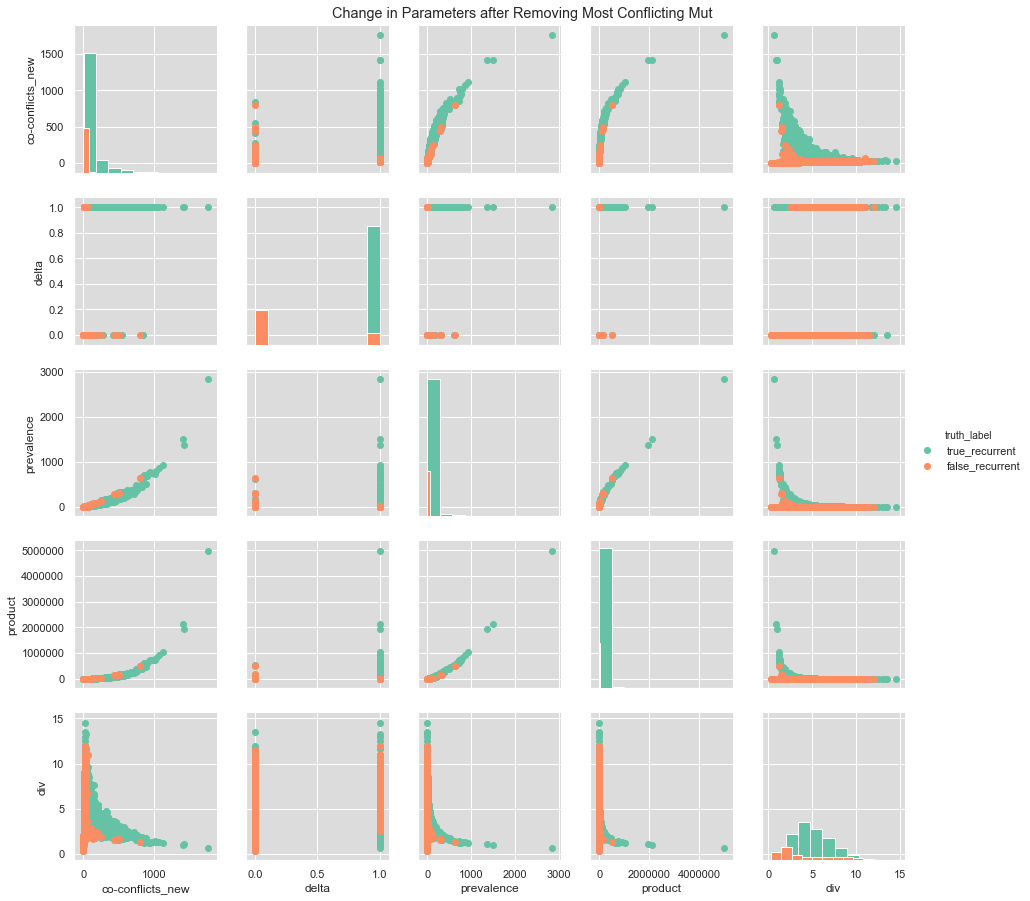

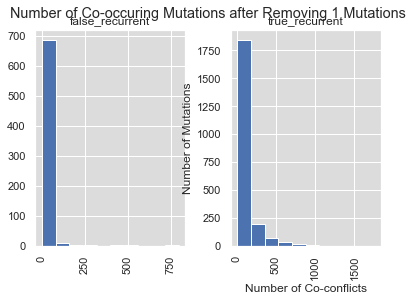

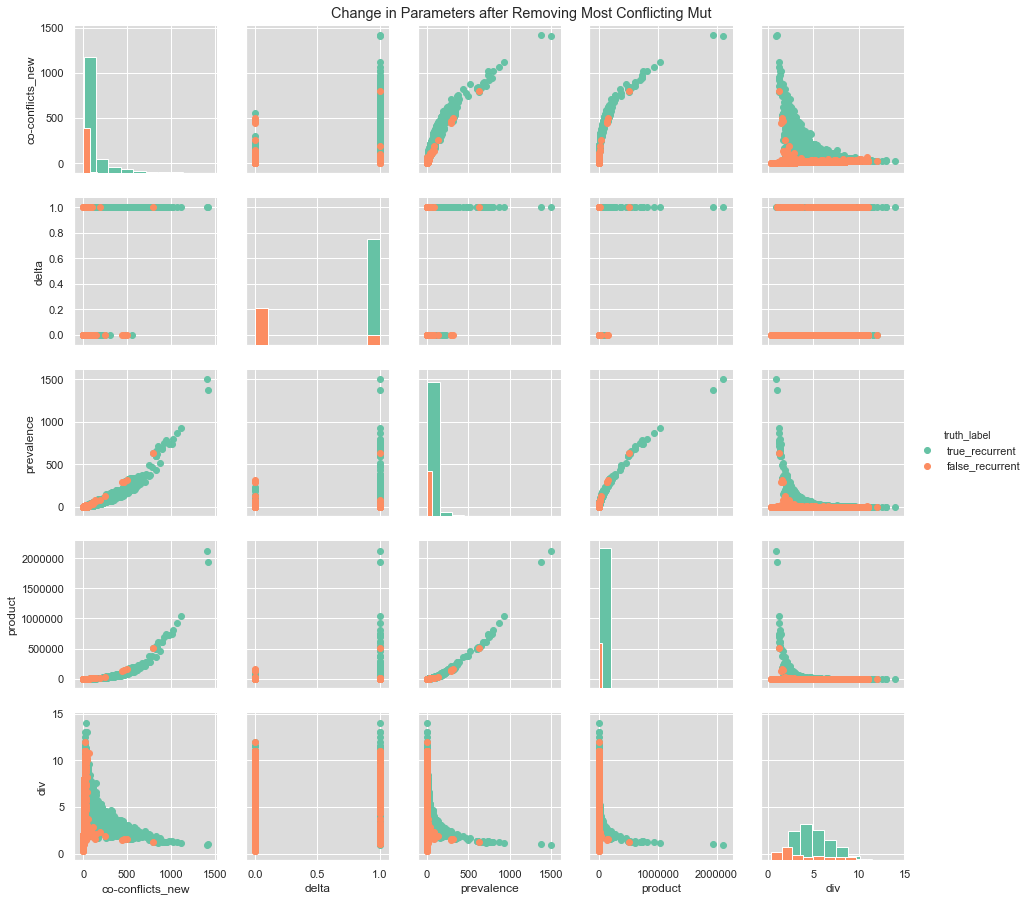

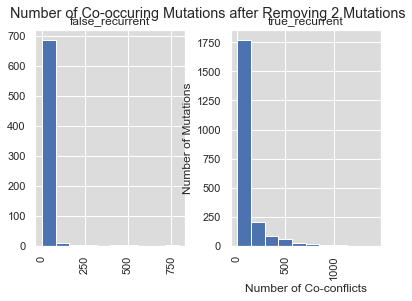

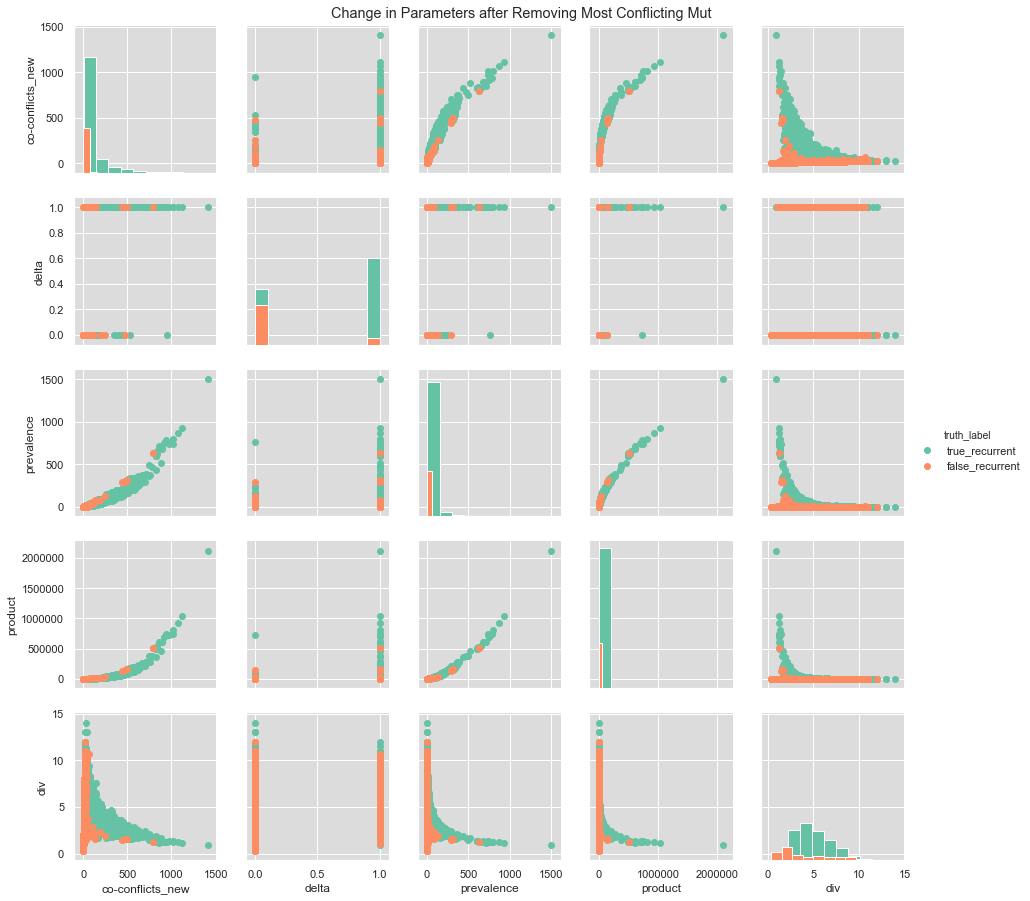

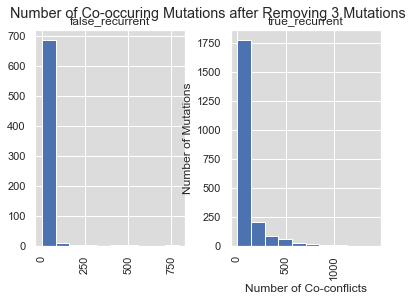

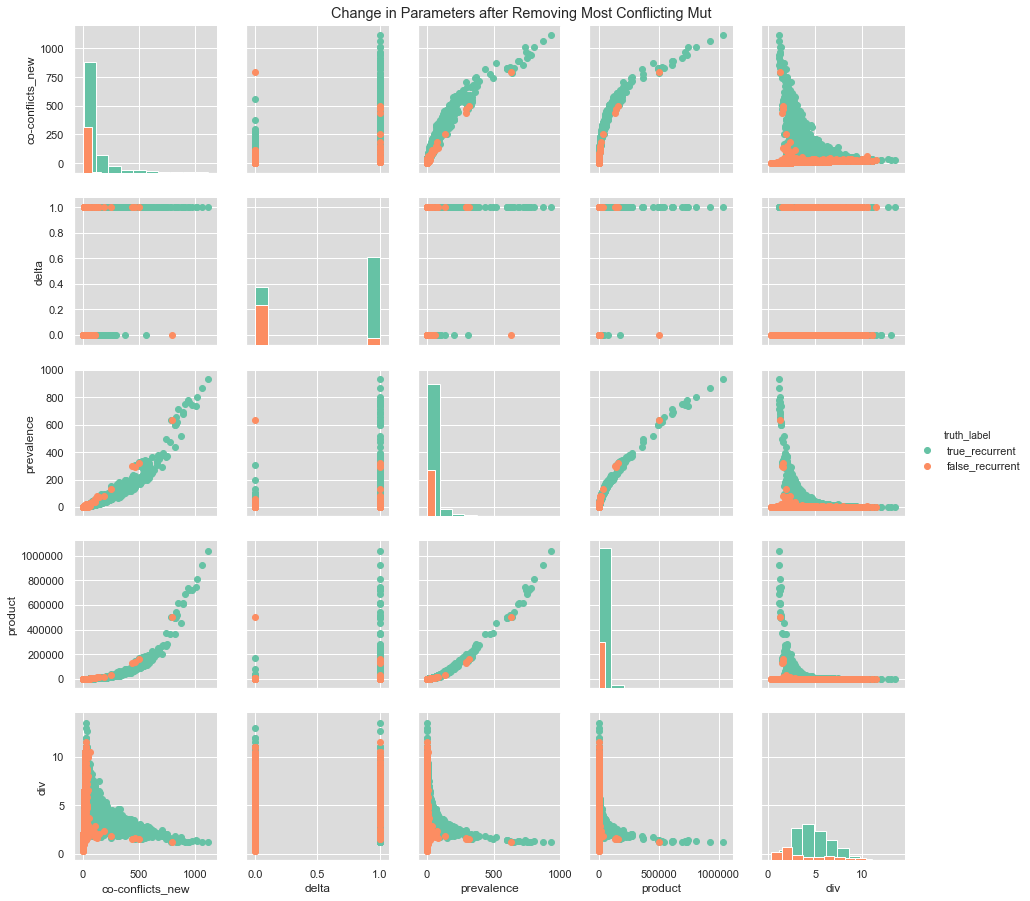

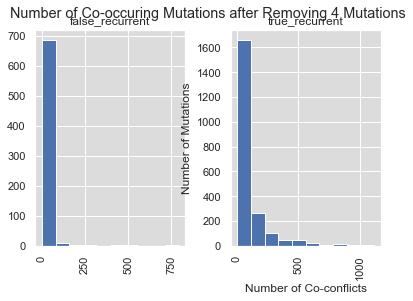

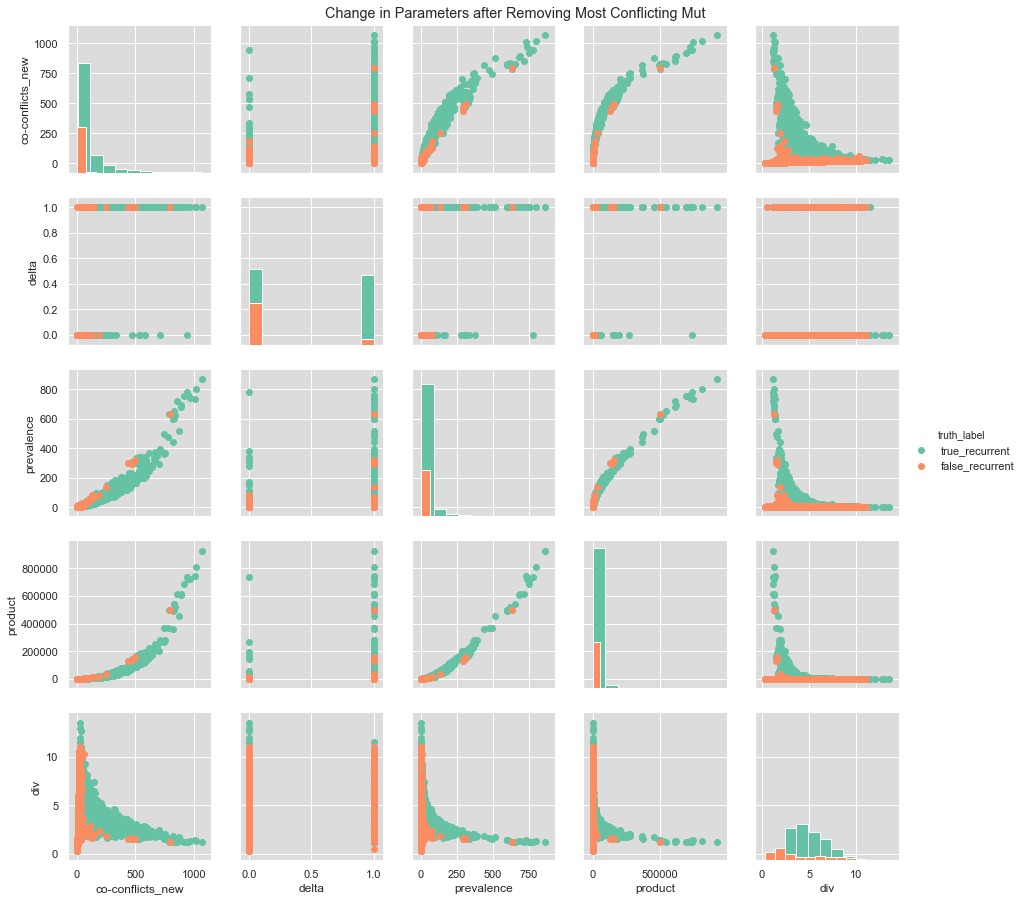

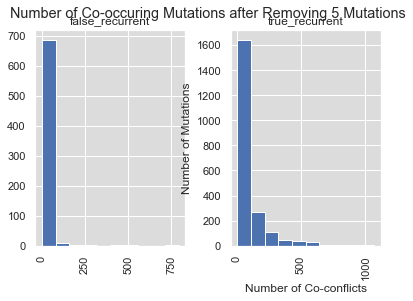

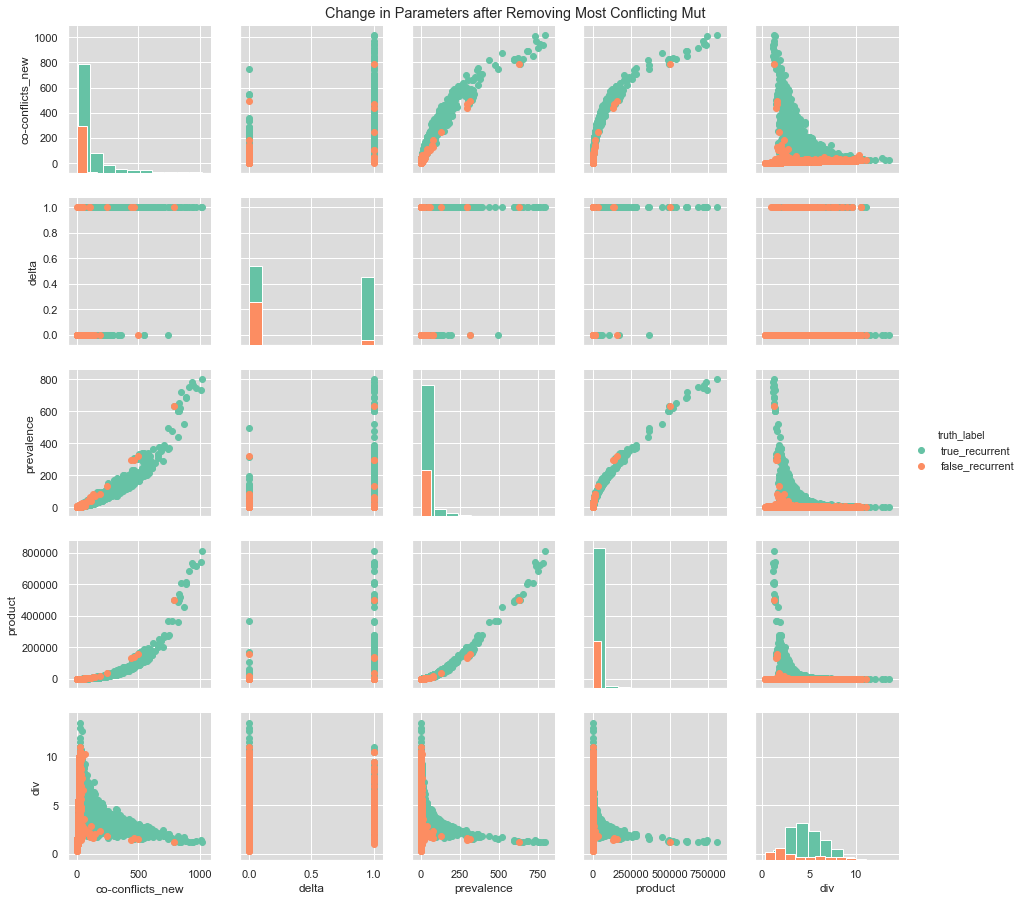

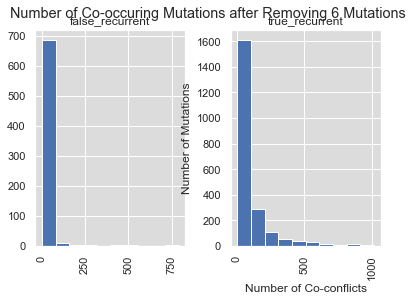

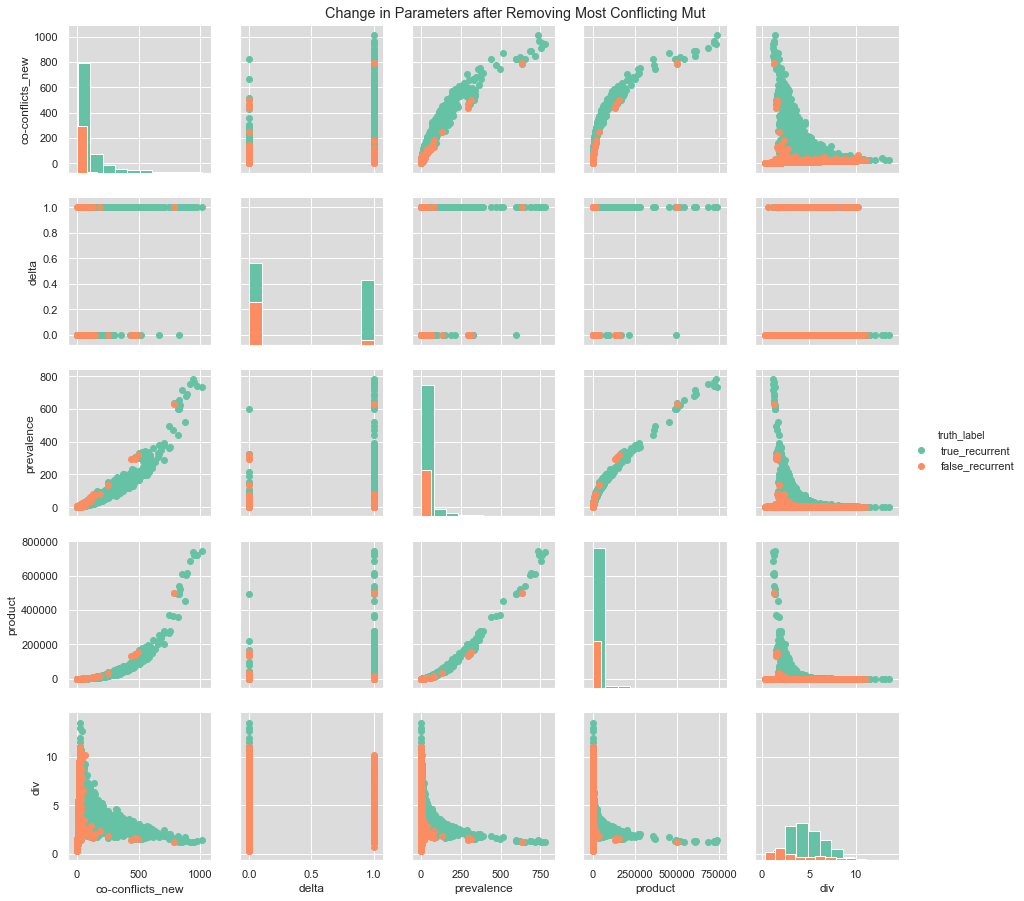

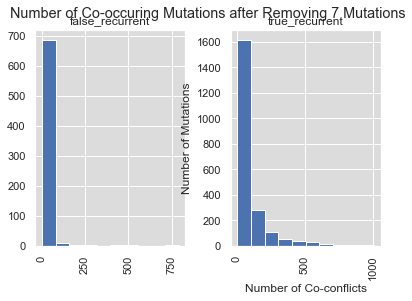

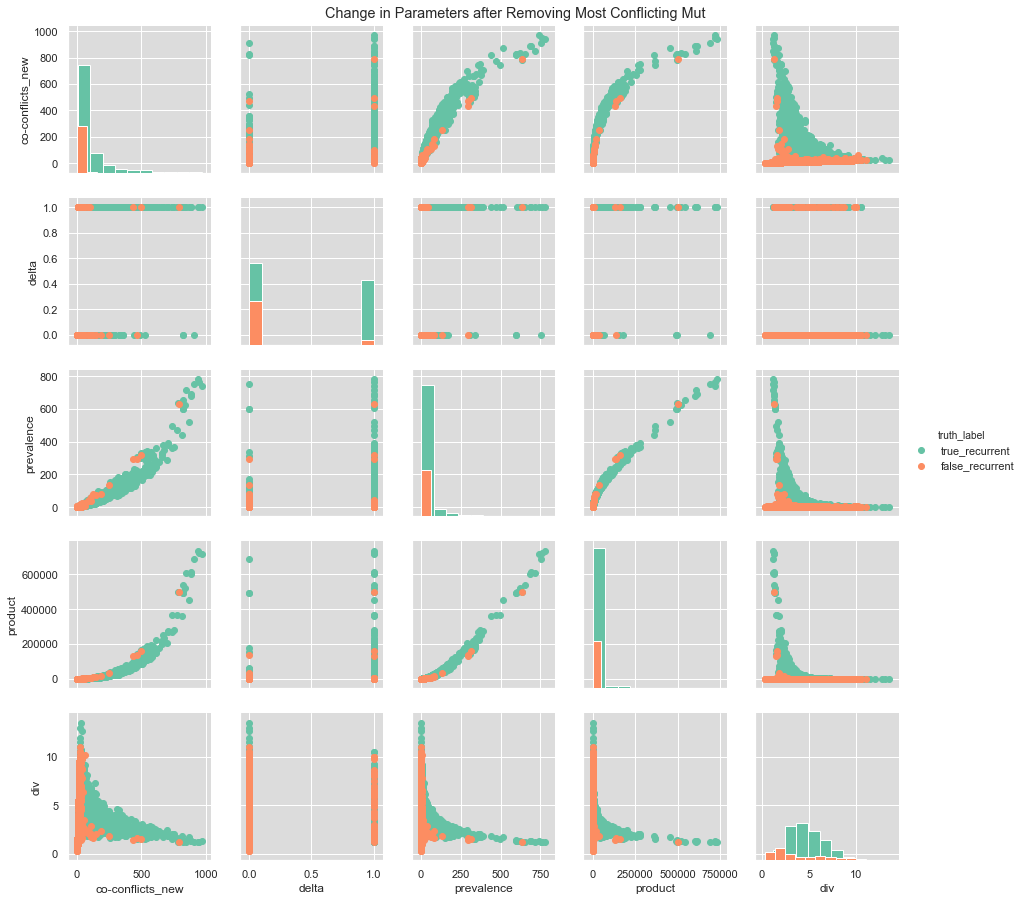

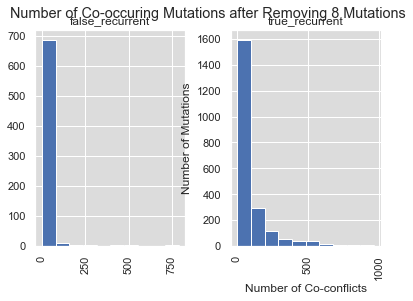

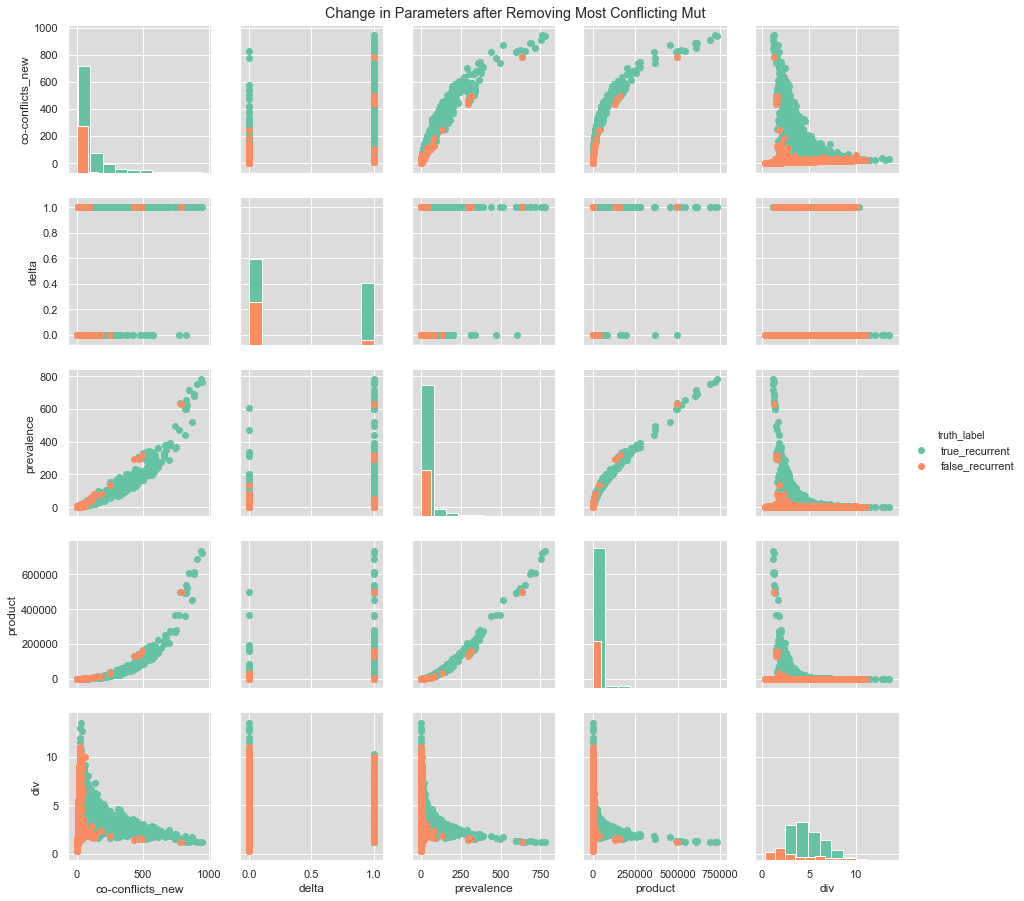

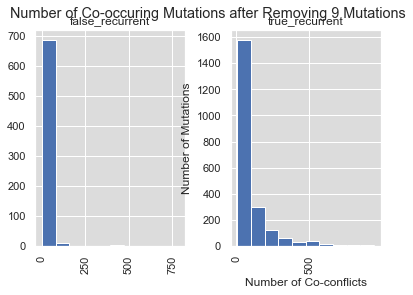

Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Eliminated a recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Eliminated a recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Eliminated a recurrent mutation!
Removed a not-recurrent mutation!
Removed a not-recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent mutation!
Removed a not-recurrent mutation!
Eliminated a recurrent mutation!
Eliminated a recurrent muta

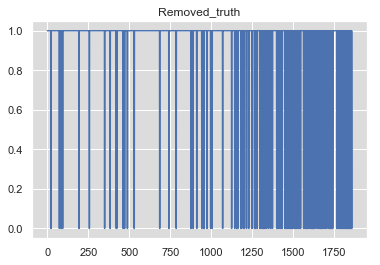

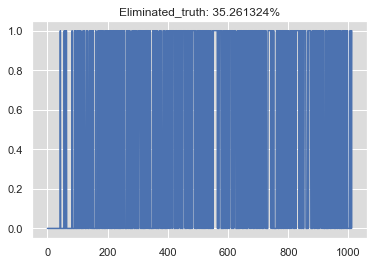

Identified [(21, 46.0), (7, 2.0), (4, 1.0), (9, 1.0), (28, 2.0), (8, 1.0), (19, 1.0), (18, 4.0), (26, 3.0), (4, 3.0), (28, 4.0), (18, 3.0), (5, 4.0), (20, 10.0), (17, 1.0), (29, 8.0), (21, 17.0), (26, 112.0), (27, 24.0), (19, 16.0), (18, 53.0), (10, 1.0), (25, 97.0), (20, 28.0), (26, 2.0), (16, 1.0), (8, 4.0), (25, 1.0), (11, 2.0), (28, 1.0), (1, 2.0), (14, 1.0), (3, 5.0), (19, 2.0), (1, 1.0), (20, 1.0), (22, 1.0), (10, 15.0), (14, 2.0), (15, 1.0), (13, 1.0), (12, 1.0), (2, 2.0), (3, 1.0), (6, 2.0), (0, 2.0), (28, 11.0), (23, 2.0), (2, 4.0), (0, 1.0), (29, 2.0), (9, 2.0), (14, 3.0), (3, 27.0), (7, 1.0), (13, 79.0), (0, 22.0), (21, 9.0), (12, 42.0), (8, 2.0), (28, 19.0), (28, 3.0), (24, 1.0), (3, 15.0), (4, 5.0), (25, 3.0), (29, 1.0), (27, 1.0), (1, 3.0), (19, 18.0), (26, 50.0), (5, 9.0), (22, 101.0), (14, 122.0), (18, 48.0), (23, 1.0), (13, 2.0), (2, 1.0), (20, 2.0), (17, 33.0), (5, 1.0), (11, 4.0), (11, 1.0), (6, 1.0), (7, 79.0), (10, 2.0), (28, 44.0), (26, 1.0), (7, 6.0), (2, 6.0), (

In [884]:
removed = iterative_removal(conflict_matrix, truth, prevalence_tape, first_gen_tape, num_recur_tape, all_conflicting)

In [815]:
removed

[(21, 46.0),
 (7, 2.0),
 (4, 1.0),
 (9, 1.0),
 (28, 2.0),
 (8, 1.0),
 (19, 1.0),
 (18, 4.0),
 (26, 3.0),
 (4, 3.0),
 (28, 4.0),
 (18, 3.0),
 (5, 4.0),
 (20, 10.0),
 (17, 1.0),
 (29, 8.0),
 (21, 17.0),
 (26, 112.0),
 (27, 24.0),
 (19, 16.0),
 (18, 53.0),
 (10, 1.0),
 (25, 97.0),
 (20, 28.0),
 (26, 2.0),
 (16, 1.0),
 (8, 4.0),
 (25, 1.0),
 (11, 2.0),
 (28, 1.0),
 (1, 2.0),
 (14, 1.0),
 (3, 5.0),
 (19, 2.0),
 (1, 1.0),
 (20, 1.0),
 (22, 1.0),
 (10, 15.0),
 (14, 2.0),
 (15, 1.0),
 (13, 1.0),
 (12, 1.0),
 (2, 2.0),
 (3, 1.0),
 (6, 2.0),
 (0, 2.0),
 (28, 11.0),
 (23, 2.0),
 (2, 4.0),
 (0, 1.0),
 (29, 2.0),
 (9, 2.0),
 (14, 3.0),
 (3, 27.0),
 (7, 1.0),
 (13, 79.0),
 (0, 22.0),
 (21, 9.0),
 (12, 42.0),
 (8, 2.0),
 (28, 19.0),
 (28, 3.0),
 (24, 1.0),
 (3, 15.0),
 (4, 5.0),
 (25, 3.0),
 (29, 1.0),
 (27, 1.0),
 (1, 3.0),
 (19, 18.0),
 (26, 50.0),
 (5, 9.0),
 (22, 101.0),
 (14, 122.0),
 (18, 48.0),
 (23, 1.0),
 (13, 2.0),
 (2, 1.0),
 (20, 2.0),
 (17, 33.0),
 (5, 1.0),
 (11, 4.0),
 (11, 1.0),
 (6, 

### Actually nan-out recurrent mutations

In [817]:
final_cells_clean = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
for (col, edit) in removed:
    ix = (final_cells_clean[col]==edit)
    # Remove this edit (no need to use it again)
    final_cells_clean.loc[ix, col] = np.nan
    
final_cells_clean.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


### Construct greedy tree using cleaned mutations

In [818]:
final_cells_clean['Label'] = '1'
final_cells_clean_labeled = split_tree(final_cells_clean)

No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.


In [819]:
final_cells_clean_labeled

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,11111110111111010.
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,11111011111011110.
2,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,240.0,11001111010.
3,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,11110110111111111111.
4,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,101011111111110.
5,0.0,53.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,111100010.
6,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,10111111101010.
7,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,11111111111101110111.
8,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,74.0,0.0,...,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,1011111111100.
9,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,11111111011111110111.


### Compute triplets correct

In [820]:
compute_triplets_correct(final_cells_clean_labeled, subsampled_ix, sample_size = 1000)

Proportion correct =  0.322


0.322

### Is our tree building method just terrible? Is the triplets correct metric wrong?

#### Remove all TRUE recurrent mutations and see what happens

In [824]:
final_cells_true = copy.deepcopy(pd.DataFrame(subsampled_record[-1]))
for (col, edit) in recurring_edits.keys():
    ix = (final_cells_true[col]==edit)
    # Remove this edit (no need to use it again)
    final_cells_true.loc[ix, col] = np.nan
    
final_cells_true.head(2)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
1,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [825]:
final_cells_true['Label'] = '1'
final_cells_true = split_tree(final_cells_true)


No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.
No more mutations to split on, returning.


In [826]:
compute_triplets_correct(final_cells_true, subsampled_ix, sample_size = 1000)

Proportion correct =  0.354


0.354

## Things to do:

1. Debug triplets correct metric 
2. Figure out why neighbor joining is crashing 
3. Try Camin-Sokal 
4. When we eliminate recurrent mutations, what is the generation/ how many cells is it present in? (prevalence)?

In [834]:
import scipy
data = scipy.spatial.distance.pdist(final_cells.values, metric='hamming')

In [835]:
from skbio import DistanceMatrix
from skbio.tree import nj

dm = DistanceMatrix(data)



In [867]:
#Construct the neighbor joining tree representing the relationship between those OTUs. This is returned as a TreeNode object.
tree = nj(dm)


KeyboardInterrupt: 

In [869]:
len(gen_occurred.keys())

3873

In [882]:
sum(truth)

2170